# **Important**: Run the cell below to load the OpenAI API key for the rest of the notebook

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# RAG evaluation with MLflow

<div style="display: flex;  height: 100px;">
    <img src="resources/MLflow-logo.png"  style="margin-left:auto; margin-right:auto"/>
</div>

MLflow is an open-source platform designed to manage the end-to-end machine learning lifecycle. It simplifies the process of tracking experiments, managing models, and deploying them into production. MLflow allows users to seamlessly package their code and models, track experiments to reproduce results, collaborate with team members, and deploy models to various environments. It provides a unified interface for different machine learning frameworks and tools, making it easier for data scientists and engineers to manage their machine learning workflows efficiently.





At a high level, MLflow provides several key tools to support the machine learning lifecycle:

1. **Tracking:** Allows users to log and query experiments to track metrics, parameters, and models.
2. **Projects:** Provides a format for packaging data science code into reusable projects, making it easier to reproduce and share experiments.
3. **Models:** Enables users to manage and version machine learning models in a systematic way, facilitating model development and deployment.
4. **Registry:** Offers a centralized repository for managing, sharing, and deploying machine learning models, ensuring consistency and collaboration across teams.
5. **Deployment:** Supports deploying models to various platforms and environments, including cloud services, edge devices, and containerized environments, enabling seamless integration into production systems.




For evaluation of the model performance, first we need a dataset of question, answer and sources from our selected documents.

# 1. Evaluation dataset

The evaluation dataset in this case, consists of a set of questions and answers and the reference page number of the question from the document that we used in our RAG scenario. 

The following cells will load the dataset and help gain insight into the contents of our evaluation data:

In [2]:
import pandas as pd
eval_data = pd.read_csv('resources/eval_data_rag.csv')
eval_data.head(10)

,question,answer,chunk,source_page
0,What are the key components of the digital tra...,The digital transformation roadmap for the ins...,THE INSURANCE \nINDUSTRY 2025:\nA Digital Tran...,0
1,What is the key driver of change in the insura...,"According to the context, technology is identi...",THE INSURANCE INDUSTRY 2025: A Digital Transfo...,1
2,"According to Professor Klaus Schwab, what char...","According to Professor Klaus Schwab, the Fourt...","Today, technology has evolved even further. \n...",1
3,Why is it important to consider the speed of i...,It is crucial to consider the speed of impleme...,"Indeed, there is much talk about adaptability ...",1
4,What are the three primary roles that actors i...,The three primary roles that actors in the ins...,THE INSURANCE INDUSTRY 2025: A Digital Transfo...,10
5,What are the three main roles discussed in the...,The three main roles discussed in the context ...,•Follower: These are the ones who are only wil...,10
6,How will the growing amount of data from conne...,The growing amount of data from connected IoT ...,Insurance 2.0: \n4 Essential Changes for the ...,10
7,What critical area of focus should insurers pr...,Insurers should prioritize investing in IT sys...,THE INSURANCE INDUSTRY 2025: A Digital Transfo...,11
8,What percentage of time do insurance industry ...,Insurance industry professionals currently spe...,as 70 % of their time performing low-value tas...,11
9,What is a critical success factor for improvin...,A critical success factor for improving custom...,Changed Customer Behaviour\nAs in any other in...,11


You can also see a histogram of the lenght of the evaluation questions.

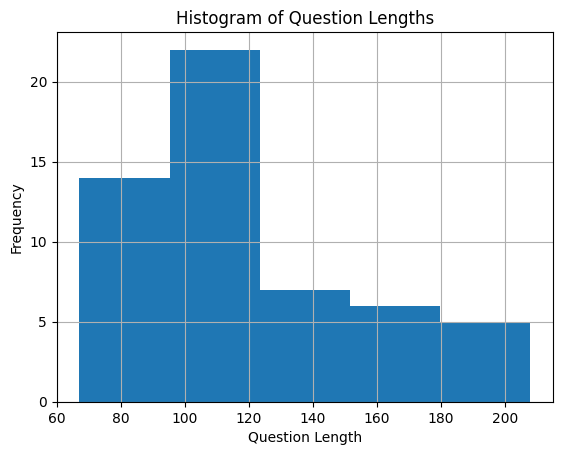

In [3]:
# Length
import matplotlib.pyplot as plt
questions = eval_data["question"].to_list()
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=5)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

# Evaluation 

When it comes to RAG evaluation, there are two different parts of the pipeline that needs to be evaluated. The Retriever engine is in charge of finding the most relevant documents. Therefore, we need to measure how successful it is in providing the correct context for the question that is asked. The Generation process involves a pretrained language model, and the quality of the answer of this model needs to be evaluated to ensure the correctness of the answer to the user question.

<div style="display: flex;  height: 300px;">
    <img src="resources/RAG_eval.png"  style="margin-left:auto; margin-right:auto"/>
</div>

## 1. Retriever evaluation

This evaluation step involves quering the most relevant parts of the document using the vector database and comparing them to the ground truth source material. Multiple metrics can be used for such evaluation. For this tutorial, we only cover the classic document retrieval metrics. However, LLM based metrics such as **Context recall**, **Context precision**, and **Context relevancy**. For more information regarding these metrics see: [RAGAS](https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics)

The metrics that we use are: [Precision](https://en.wikipedia.org/wiki/Precision_and_recall), [Recall](https://en.wikipedia.org/wiki/Precision_and_recall), and [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain).

In [4]:
eval_data_ret = eval_data[['question','source_page']]
eval_data_ret['source_page'] = eval_data_ret['source_page'].apply(lambda d: [str(d)])

/tmp/ipykernel_14433/1397389640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data_ret['source_page'] = eval_data_ret['source_page'].apply(lambda d: [str(d)])


In [5]:
from langchain_community.document_loaders import PyPDFLoader
doc_address = 'resources/Noria_eBook_The_Insurance_Industry_2025_171205_v8.pdf' #PDF file address for question answering.

# Decode the file
loader = PyPDFLoader(doc_address)

In [6]:
eval_data_ret.head()

,question,source_page
0,What are the key components of the digital tra...,[0]
1,What is the key driver of change in the insura...,[1]
2,"According to Professor Klaus Schwab, what char...",[1]
3,Why is it important to consider the speed of i...,[1]
4,What are the three primary roles that actors i...,[10]


In [8]:
from typing import List
import mlflow
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

def evaluate_retriever():
    list_of_documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=250)
    docs = text_splitter.split_documents(list_of_documents)
    embedding_function = OpenAIEmbeddings()
    retriever = Chroma.from_documents(docs, embedding_function).as_retriever()

    def retrieve_doc_ids(question: str) -> List[str]:
        docs = retriever.get_relevant_documents(question)
        # print([doc.metadata["source"]+"_page_"+str(doc.metadata['page']) for doc in docs])
        return [str(doc.metadata['page']) for doc in docs]

    def retriever_model_function(question_df: pd.DataFrame) -> pd.Series:
        return question_df["question"].apply(retrieve_doc_ids)

    with mlflow.start_run():
        return mlflow.evaluate(
            model=retriever_model_function,
            data=eval_data_ret,
            model_type="retriever",
            targets="source_page",
            evaluators="default",
        )


result_ret = evaluate_retriever()


# display(result1.tables["eval_results_table"])

/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/mlflow/models/evaluation/base.py:521: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
/home/ramin/anaconda3/envs/LLM_worksh

In [9]:
result_ret.metrics

{'precision_at_3/mean': 0.4506172839506172,
 'precision_at_3/variance': 0.04180003048315804,
 'precision_at_3/p90': 0.6666666666666666,
 'recall_at_3/mean': 0.9444444444444444,
 'recall_at_3/variance': 0.05246913580246911,
 'recall_at_3/p90': 1.0,
 'ndcg_at_3/mean': 0.9036161048729573,
 'ndcg_at_3/variance': 0.05797292905739502,
 'ndcg_at_3/p90': 1.0}

In [10]:
result_ret.tables['eval_results_table']

,question,source_page,outputs,precision_at_3/score,recall_at_3/score,ndcg_at_3/score
0,What are the key components of the digital tra...,[0],"[0, 23, 13, 1]",0.333333,1,1.000000
1,What is the key driver of change in the insura...,[1],"[10, 1, 20, 10]",0.333333,1,0.630930
2,"According to Professor Klaus Schwab, what char...",[1],"[1, 7, 9, 9]",0.333333,1,1.000000
3,Why is it important to consider the speed of i...,[1],"[1, 9, 9, 17]",0.333333,1,0.919721
4,What are the three primary roles that actors i...,[10],"[10, 20, 17, 2]",0.333333,1,1.000000
5,What are the three main roles discussed in the...,[10],"[10, 1, 3, 10]",0.333333,1,1.000000
6,How will the growing amount of data from conne...,[10],"[7, 15, 12, 10]",0.000000,0,0.000000
7,What critical area of focus should insurers pr...,[11],"[11, 15, 21, 19]",0.333333,1,1.000000
8,What percentage of time do insurance industry ...,[11],"[11, 11, 10, 8]",0.666667,1,1.000000
9,What is a critical success factor for improvin...,[11],"[11, 15, 5, 11]",0.333333,1,1.000000


Try a different retriever setting to se if you can improve the precision mean or find the context at failing retrieval cases. Check out different retrieval settings fron langchain as well as different text splitting methods: [Retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers/vectorstore/), [text_splitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/)

In [ ]:
from typing import List
import mlflow
from langchain.text_splitter import *
from langchain_community.embeddings.openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

def evaluate_alternate_retriever():
    list_of_documents = loader.load()
    # TODO: write your alternate retrieval strategy to check the results
    # ....

    def retrieve_doc_ids(question: str) -> List[str]:
        docs = retriever.get_relevant_documents(question)
        # print([doc.metadata["source"]+"_page_"+str(doc.metadata['page']) for doc in docs])
        return [str(doc.metadata['page']) for doc in docs]

    def retriever_model_function(question_df: pd.DataFrame) -> pd.Series:
        return question_df["question"].apply(retrieve_doc_ids)

    with mlflow.start_run():
        return mlflow.evaluate(
            model=retriever_model_function,
            data=eval_data_ret,
            model_type="retriever",
            targets="source_page",
            evaluators="default",
        )


result_ret_alt = evaluate_alternate_retriever()

display(result_ret_alt.tables["eval_results_table"])

## 2. Generation evaluation

For this task, we use an LLM model as a judge to asses the output of the RAG in terms of the quality of the answers provided. The metric that we use in this tutorial is the Relevance metric offered by MLflow. There are other metrics that are generated by a judge LLM. For more info check out [RAGAS](https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics).

In [12]:
eval_df_qa = pd.DataFrame(eval_data['question'])
eval_df_qa.head()

,question
0,What are the key components of the digital tra...
1,What is the key driver of change in the insura...
2,"According to Professor Klaus Schwab, what char..."
3,Why is it important to consider the speed of i...
4,What are the three primary roles that actors i...


In [13]:
list_of_documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(list_of_documents)
embedding_function = OpenAIEmbeddings()
docsearch = Chroma.from_documents(docs, embedding_function)

In [14]:
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(temperature=0, streaming=True),
    chain_type="stuff",
    retriever=docsearch.as_retriever(fetch_k=3),
    return_source_documents=True,
)

In [ ]:
from mlflow.metrics.genai import relevance
relevance_metric = relevance(
    model="openai:/gpt-3.5-turbo"
)

def model(input_df):
    return input_df["question"].map(qa).tolist()

with mlflow.start_run():
    results_qa = mlflow.evaluate(
        model,
        eval_df_qa,
        model_type="question-answering",
        evaluators="default",
        predictions="result",
        extra_metrics=[relevance_metric, mlflow.metrics.latency()],
        evaluator_config={
            "col_mapping": {
                "inputs": "question",
                "context": "source_documents",
            }
        },
    )
    print(results_qa.metrics)

display(results_qa.tables["eval_results_table"])

/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/mlflow/models/evaluation/base.py:521: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
/home/ramin/anaconda3/envs/LLM_workshop/lib/python3.11/site-packages/mlflow/models/evaluation/base.py:521: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
2024/04/24 14:31:05 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/04/24 14:31:05 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
/home/ramin/anaconda3/envs/LLM_workshop/lib/pyt

  0%|          | 0/1 [00:00<?, ?it/s]

2024/04/24 14:33:58 WARNING mlflow.metrics.metric_definitions: Failed to load 'toxicity' metric (error: ModuleNotFoundError("No module named 'evaluate'")), skipping metric logging.
2024/04/24 14:33:58 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'toxicity' because it returned None.
2024/04/24 14:33:58 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for flesch kincaid metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2024/04/24 14:33:58 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'flesch_kincaid_grade_level' because it returned None.
2024/04/24 14:33:58 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for automated readability index metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2024/04/24 14:33:58 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'ari_grade_level' because i

  0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
results_qa.metrics